In [1]:
import numpy as np
import pandas as pd
import warnings
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
#from dtreeviz.trees import *
from sklearn import tree 
from IPython.display import SVG
from graphviz import Source

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

warnings.filterwarnings('ignore')

import pickle

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### Load Data

In [2]:
# file path
DATA_DIR = "./data"
ORI_DATA_PATH = DATA_DIR + "/diabetic_data.csv"
MAP_PATH = DATA_DIR + "/IDs_mapping.csv"
OUTPUT_DATA_PATH = DATA_DIR + "/preprocessed_data.csv"
df = pd.read_csv(OUTPUT_DATA_PATH)
# df.info()
# print('>30 readmmission', df['readmitted'][df['readmitted'] == 2].count())
# print('<30 readmmission', df['readmitted'][df['readmitted'] == 1].count())
# print('Never readmmission', df['readmitted'][df['readmitted'] == 0].count())

In [3]:
feature_set = ['race', 'gender', 'age',
               'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
               'time_in_hospital', 'num_lab_procedures',
               'num_procedures',
               'num_medications', 'number_outpatient', 'number_emergency',
               'number_inpatient', 'diag_1', 'number_diagnoses',
               'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
               'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
               'tolbutamide',
               'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
               'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin',
               'glipizide-metformin', 'glimepiride-pioglitazone',
               'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
               'diabetesMed', 'num_med_changed', 'num_med_taken']

X = df[feature_set]
y = df['readmitted']

# 不均匀采样
smt = SMOTE(random_state=20)
# train_input_new, train_output_new = smt.fit_sample(input, label)
# train_input_new = pd.DataFrame(train_input_new, columns=list(input.columns))

# X_train, X_test, Y_train, Y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)
# print("nums of train/test set: ", len(X_train), len(X_test), len(Y_train), len(Y_test))


In [4]:
X_train_old, X_test, Y_train_old, Y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_train, Y_train = smt.fit_sample(X_train_old, Y_train_old)
X_train = pd.DataFrame(X_train, columns=list(X_train_old.columns))

print("nums of train/test set: ", len(X_train), len(X_test), len(Y_train), len(Y_test))

nums of train/test set:  111579 17312 111579 17312


### XGBoost Model

In [24]:
xg_reg = xgb.XGBClassifier()

# print("Cross Validation score: ", np.mean(cross_val_score(xg_reg, X_train, Y_train, cv=10)))  # 10-fold 交叉验证
xg_reg.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
# save the model to disk
filename = '/Users/alexisbarrett/301/project/freesinger/readmission_prediction/freesinger_xgb.sav'
pickle.dump(xg_reg, open(filename, 'wb'))

In [7]:
# load the model from disk
filename = '/Users/alexisbarrett/301/project/freesinger/readmission_prediction/freesinger_xgb.sav'
xg_reg = pickle.load(open(filename, 'rb'))

### Evaluate XGBoost

In [ ]:
Y_test_predict = xg_reg.predict(X_test)
acc = accuracy_score(Y_test, Y_test_predict)
mat = confusion_matrix(Y_test, Y_test_predict)
f1 = f1_score(Y_test, Y_test_predict, average='weighted')
print("Accuracy: ", acc)
print("F1 score: ", f1)
print("Confusion matrix: \n", mat)
print('Overall report: \n', classification_report(Y_test, Y_test_predict))

### XGB Heatmap

In [ ]:
# Save confusion matrix figure
plt.figure(figsize=(4, 4))
sns.set(font_scale=1)
sns.heatmap(mat, square=True, annot=True, cmap='Blues')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('Random Forest\n ACC: {0:.2f}%\n F1: {1:.2f}%'.format(acc * 100, f1 * 100))
plt.savefig('./images/XGBoost.png')

### XGB Most Important Features Viz

                     Feature  Importance
1                     gender    0.117564
12          number_inpatient    0.090221
32                   insulin    0.087101
4   discharge_disposition_id    0.070824
17                 metformin    0.068720


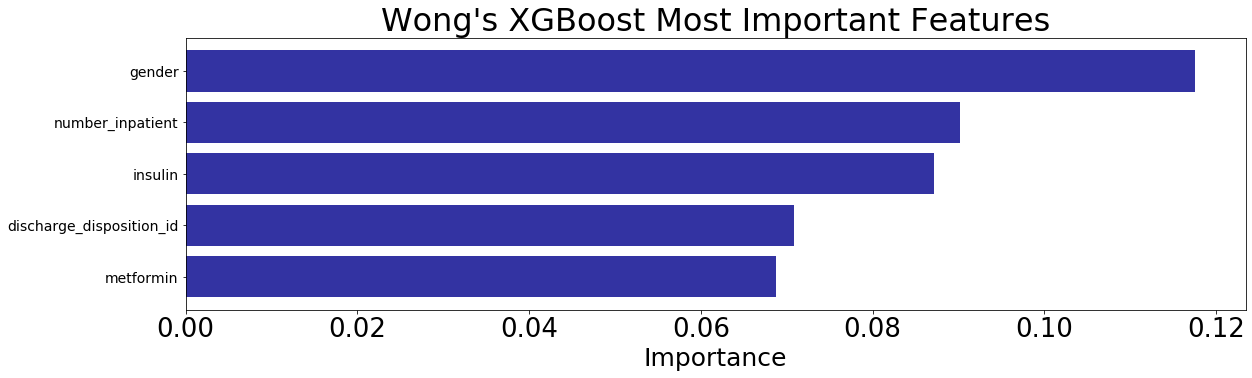

In [8]:
feature_names = X_train.columns
feature_imports = xg_reg.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(5, "Importance")
print(most_imp_features)
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(19, 5))
plt.rc('xtick',labelsize=26)
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8, color='darkblue')
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=25)
plt.title("Wong's XGBoost Most Important Features", fontsize=32)
plt.savefig('./images/XGBfeatImportance.jpg')
# plt.show()

### XGB Tree????

### Random Forest

In [13]:
forest = RandomForestClassifier(n_estimators=10, max_depth=120, criterion="entropy")
# print("Cross Validation Score: ", np.mean(cross_val_score(forest, X_train, Y_train, cv=10)))


In [14]:
forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=120, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
# save the model to disk
filename = '/Users/alexisbarrett/301/project/freesinger/readmission_prediction/freesinger_rf.sav'
pickle.dump(forest, open(filename, 'wb'))

In [9]:
# load the model from disk
filename = '/Users/alexisbarrett/301/project/freesinger/readmission_prediction/freesinger_rf.sav'
forest = pickle.load(open(filename, 'rb'))

### Eval RF

In [48]:
Y_test_predict = forest.predict(X_test)
acc = accuracy_score(Y_test, Y_test_predict)
mat = confusion_matrix(Y_test, Y_test_predict)
f1 = f1_score(Y_test, Y_test_predict, average='weighted')
print("Accuracy: ", acc)
print("F1 score: ", f1)
print("Confusion matrix: \n", mat)
print('Overall report: \n', classification_report(Y_test, Y_test_predict))

Accuracy:  0.524145101663586
F1 score:  0.49497949794741936
Confusion matrix: 
 [[6848  250 2158]
 [1155  142  617]
 [3750  308 2084]]
Overall report: 
               precision    recall  f1-score   support

           0       0.58      0.74      0.65      9256
           1       0.20      0.07      0.11      1914
           2       0.43      0.34      0.38      6142

    accuracy                           0.52     17312
   macro avg       0.40      0.38      0.38     17312
weighted avg       0.49      0.52      0.49     17312



### RF Heatmap

In [50]:
# Save confusion matrix figure
mat = confusion_matrix(Y_test, Y_test_predict)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1)
sns.heatmap(mat, square=True, annot=True, cmap='Reds')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('Random Forest\n ACC: {0:.2f}%\n F1: {1:.2f}%'.format(acc * 100, f1 * 100))
plt.savefig('./images/randomForest.png')

ValueError: Colormap darkReds is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

<Figure size 288x288 with 0 Axes>

### RF Most Important Features

               Feature  Importance
7   num_lab_procedures    0.103609
9      num_medications    0.096555
6     time_in_hospital    0.084600
2                  age    0.078012
13              diag_1    0.071177


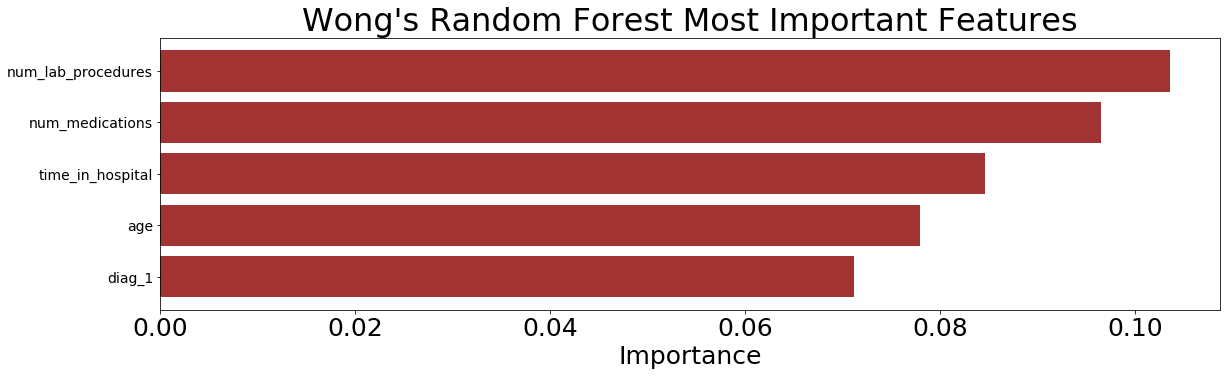

In [10]:
feature_names = X_train.columns
feature_imports = forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(5, "Importance")
print(most_imp_features)
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(19, 5))
plt.rc('xtick',labelsize=25)
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8, color='darkred')
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=25)
plt.title("Wong's Random Forest Most Important Features", fontsize=32)
plt.savefig('./images/RFfeatImportance.jpg')
# plt.show()

### RF Tree

In [16]:
estimator = forest.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ["Never readmission", "<30 readmission", ">30 readmission"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

KeyboardInterrupt: 

In [9]:
export_graphviz(estimator)
graph = Source(export_graphviz(estimator, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

KeyboardInterrupt: 

In [15]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(forest, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.